In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
import os 

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../'
helper_dir = os.path.join(base_dir, 'helper')
png_dir = os.path.join(base_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/defillama.py
%run {helper_dir}/colors.py

## Define helper functions

In [4]:
def calc_portfolio_ret_avg(tokens_mean_rets, weights, ndays_per_year=365):
    # Calculates the annualized average return of a portfolio. 
    #
    # tokens_mean_rets: list, numpy array, or Series
    #    Average daily returns of individual tokens in the portfolio.
    # weights: list or numpy array
    #    Proportion of each token. Sum to 1.
    # ndays_per_year: int
    #    number of trading days in a year.
    return np.dot(tokens_mean_rets, weights) * ndays_per_year

In [5]:
def calc_portfolio_ret_std(tokens_simple_rets, weights, ndays_per_year=365):
    # Calculates the annualized volatility of a portfolio.     
    #
    # tokens_simple_rets: data frame 
    #     Simple daily returns where each column is a token and each row is a date.
    # weights: list, numpy array, or Series
    #     Proportion of each token. Sum to 1.
    # ndays_per_year: int 
    #     number of trading days in a year.
    return np.dot(np.dot(tokens_simple_rets.cov(), weights), weights)**(1/2) * np.sqrt(ndays_per_year) 

In [6]:
def generate_weights(ntokens):
    # Generates portfolio weights randomly.
    #
    # ntokens: number of tokens in the portfolio
    rand = np.random.random(ntokens)
    rand /= rand.sum()
    return rand

## Download historical prices from DeFiLlama

In [7]:
# get the prices of the following tokens from the corresponding chains/sources
# note that token address can be in either lower or upper case. 
dd = {'0xE5417Af564e4bFDA1c483642db72007871397896':'polygon',   # GNS on polygon
      '0xfc5a1a6eb076a2c7ad06ed22c90d7e710e35ad0a':'arbitrum',  # GMX on arbitrum
      '0x62edc0692BD897D2295872a9FFCac5425011c661':'avax',      # GMX on avalanche
      }

In [8]:
obj = DefiLlama()

In [9]:
# DeFiLlama currently doesn't offer an API for bulk downloading historical prices. 
# So I wrote a method to call its snapshot price API iteratively to get past daily 
# open (00:00:00) or close (23:59:59)prices. It is slow so use it judiciously.
#
# the earliest available date for GNS is '2021-11-02', GMX is available for earlier dates
df = obj.get_tokens_hist_prices(dd, start='2021-11-02', end='2022-09-30', type='close')

In [10]:
# show price data
df = df.dropna()
df.head()

,GMX,GNS
date,,
2021-11-02,34.1970,1.0625
2021-11-03,39.1878,1.2486
2021-11-04,35.5765,1.1246
2021-11-05,36.8405,1.0967
2021-11-06,36.4247,1.0808


## Calculate and Plot the Efficient Frontier and Min-Variance Portfolio

Portfolio is made up of only two tokens, namely, GMX and GNS.

In [11]:
# calculate daily returns
simple_rets = df.pct_change()
simple_rets.head()

,GMX,GNS
date,,
2021-11-02,NaN,NaN
2021-11-03,0.1459,0.1752
2021-11-04,-0.0922,-0.0994
2021-11-05,0.0355,-0.0248
2021-11-06,-0.0113,-0.0145


In [12]:
# calculate annualized mean return and volatility of the GMX-GNS portfolio using all downloaded data, assuming equal weights
weights = [1/2, 1/2]
print('Mean return:', calc_portfolio_ret_avg(simple_rets.mean(), weights, ndays_per_year=365))
print('Volatility:', calc_portfolio_ret_std(simple_rets, weights, ndays_per_year=365))

Mean return: 1.8722139956176884
Volatility: 1.3747770257122975


In [13]:
# randomly generate 1000 pairs of weights, and every time we have a new pair of weights, we have a new portfolio with a different
# mean return and volatility. 
rets = []
stds = []
wts = []
for i in range(1000):
    weights = generate_weights(2)
    rets.append(calc_portfolio_ret_avg(simple_rets.mean(), weights))
    stds.append(calc_portfolio_ret_std(simple_rets, weights))
    wts.append(weights)

In [14]:
# find the pair of weights that results in the minimum variance portfolio
minvar_wt_gmx = wts[stds.index(min(stds))][0]
minvar_wt_gns = wts[stds.index(min(stds))][1]

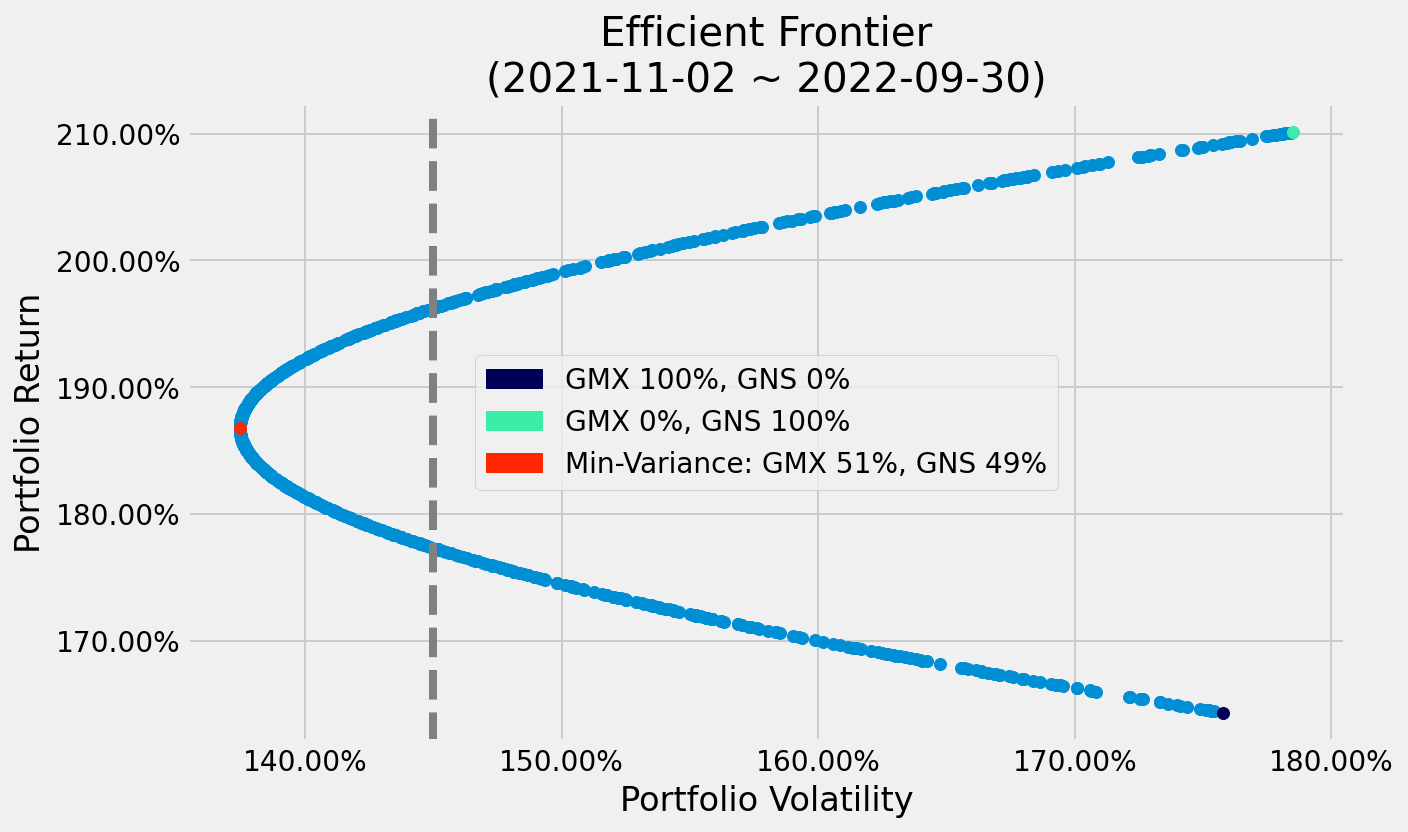

In [15]:
# plot the efficient frontier and the min-variance portfolio
plt.scatter(stds, rets)
plt.scatter(simple_rets.std()['GMX']*np.sqrt(365), simple_rets.mean()['GMX']*365, c=gmx_blue)
plt.scatter(simple_rets.std()['GNS']*np.sqrt(365), simple_rets.mean()['GNS']*365, c=gns_green)
plt.scatter(min(stds), rets[stds.index(min(stds))], c=fivethirtyeight_red) # min-variance portfolio
plt.axvline(x=1.45, c='gray', linestyle='--')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2))
plt.title('Efficient Frontier\n({:} ~ {:})'.format(str(df.index[0]), str(df.index[-1])))
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')

# make legend
l1 = mpatches.Patch(color=gmx_blue,  label='GMX 100%, GNS 0%')
l2 = mpatches.Patch(color=gns_green, label='GMX 0%, GNS 100%')
l3 = mpatches.Patch(color=fivethirtyeight_red, label='Min-Variance: GMX {:.0%}, GNS {:.0%}'.format(minvar_wt_gmx, minvar_wt_gns))
plt.legend(handles=[l1, l2, l3], loc='center')

# save
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'efficient_frontier_gmx_gns.png'), dpi=300)

#### Remark: 

- each dot is a portfolio.
- given a volatility, draw a vertical line, and you want to pick the portfolio at the intersection of the vertical line and the top half of the blue curve.
- if you want to mute volatility, the min-variance portfolio (red dot) is a good choice.

## Calculate min-variance portfolios for different start dates

In [16]:
minvar_stds = []
minvar_rets = []
minvar_wts_gmx = []
minvar_wts_gns = []
n = int(len(simple_rets) * 0.7)  # use at least 30% data for calculation to ensure robustness of results
for i in range(n):
    ha = simple_rets.iloc[i:]
    rets = []
    stds = []
    wts = []
    for i in range(500): # generate 500 pairs of weights and hence 500 new portfolios. Lower it to decrease computation time.
        weights = generate_weights(2)
        rets.append(calc_portfolio_ret_avg(ha.mean(), weights))
        stds.append(calc_portfolio_ret_std(ha, weights))
        wts.append(weights)
    minvar_stds.append(min(stds)) 
    minvar_rets.append(rets[stds.index(min(stds))])
    minvar_wts_gmx.append(wts[stds.index(min(stds))][0])
    minvar_wts_gns.append(wts[stds.index(min(stds))][1])

In [17]:
# collect all the min-variance portfolios into a data frame
minvar_portfolios = pd.DataFrame({"std": minvar_stds, "ret": minvar_rets, "GMX %":minvar_wts_gmx, "GNS %":minvar_wts_gns}, 
                                 index=simple_rets.index[:n])
minvar_portfolios.index.name = 'start date'
minvar_portfolios.head().style.format('{:.0%}')

,std,ret,GMX %,GNS %
start date,,,,
2021-11-02,137%,187%,51%,49%
2021-11-03,137%,187%,51%,49%
2021-11-04,137%,170%,51%,49%
2021-11-05,136%,181%,51%,49%
2021-11-06,137%,181%,51%,49%


In [18]:
minvar_portfolios.tail().style.format('{:.0%}')

,std,ret,GMX %,GNS %
start date,,,,
2022-06-16,109%,408%,41%,59%
2022-06-17,108%,444%,42%,58%
2022-06-18,107%,409%,43%,57%
2022-06-19,107%,429%,43%,57%
2022-06-20,107%,414%,44%,56%


## Analyze these min-variance portfolios

In [19]:
def plt_histogram(x, title, xlab, nbins=50, xaxis_nticks=8):
    x.hist(bins=nbins)
    plt.title(title)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    steps  = (max(x) - min(x)) / xaxis_nticks
    plt.xticks(np.arange(min(x), max(x)+steps, steps))
    plt.xlabel(xlab)
    plt.ylabel('Frequency')

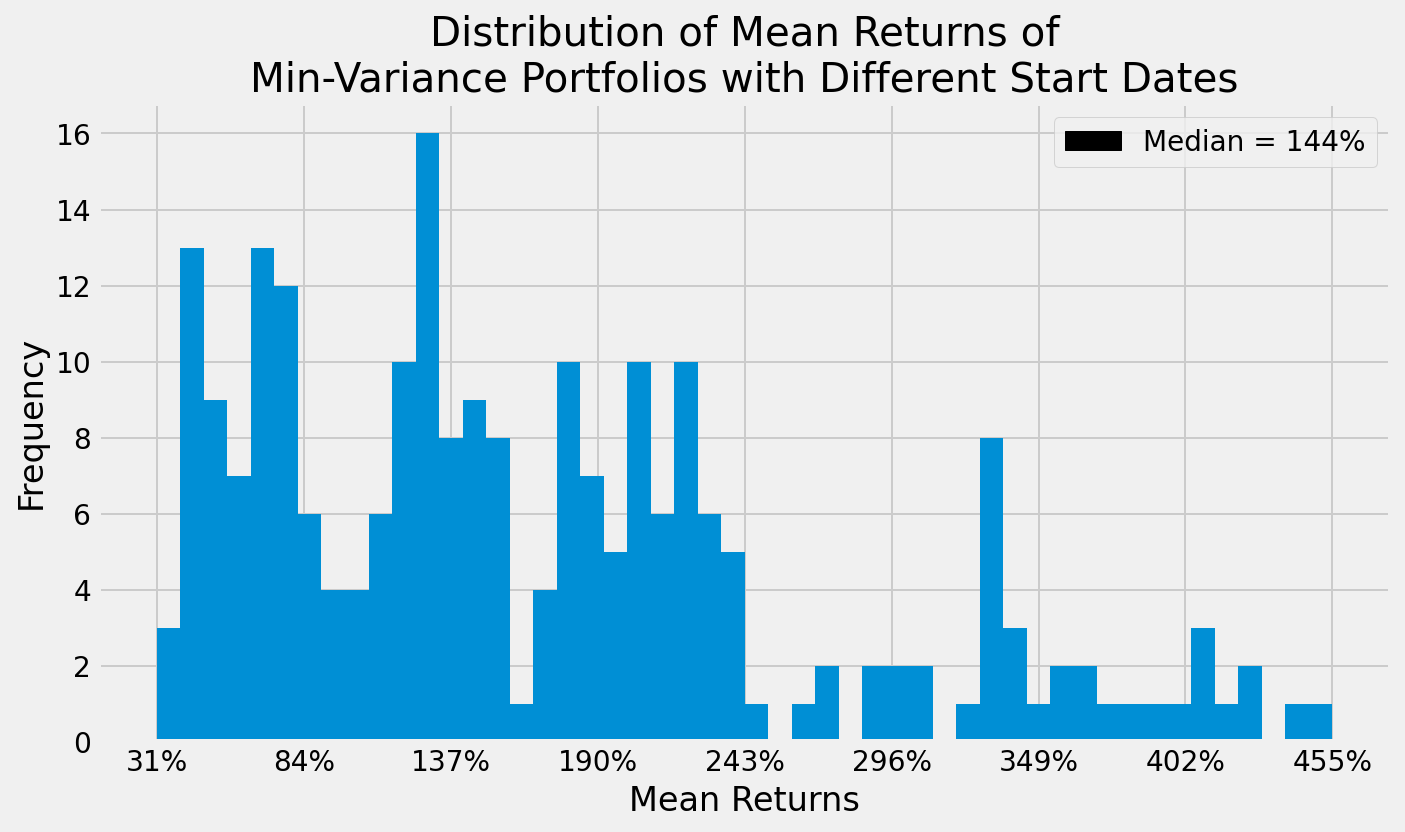

In [20]:
# plot distribution of mean returns
fig_title = 'Distribution of Mean Returns of\nMin-Variance Portfolios with Different Start Dates'
plt_histogram(minvar_portfolios.ret, fig_title, xlab='Mean Returns')

# make legend to show the median value
med = minvar_portfolios['ret'].median()
l1 = mpatches.Patch(color='black',  label='Median = {:.0%}'.format(med))
plt.legend(handles=[l1], loc='upper right')

# save
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'minvar_portfolios_meanrets.png'), dpi=300)

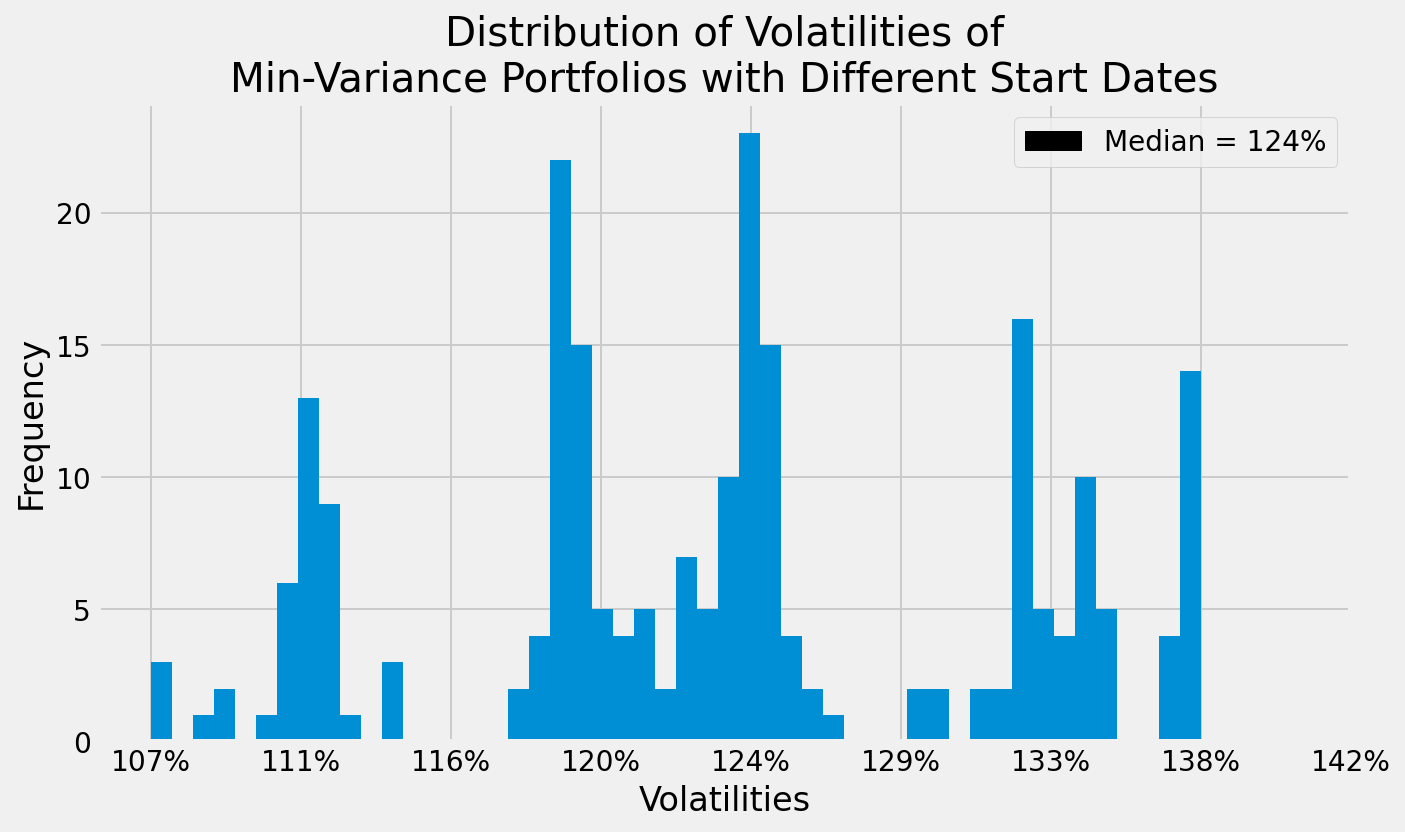

In [21]:
# plot distribution of volatilities
fig_title = 'Distribution of Volatilities of\nMin-Variance Portfolios with Different Start Dates'
plt_histogram(minvar_portfolios['std'], fig_title, xlab='Volatilities', xaxis_nticks=7)

# make legend to show the median value
med = minvar_portfolios['std'].median()
l1 = mpatches.Patch(color='black',  label='Median = {:.0%}'.format(med))
plt.legend(handles=[l1], loc='upper right')

# save
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'minvar_portfolios_vols.png'), dpi=300)

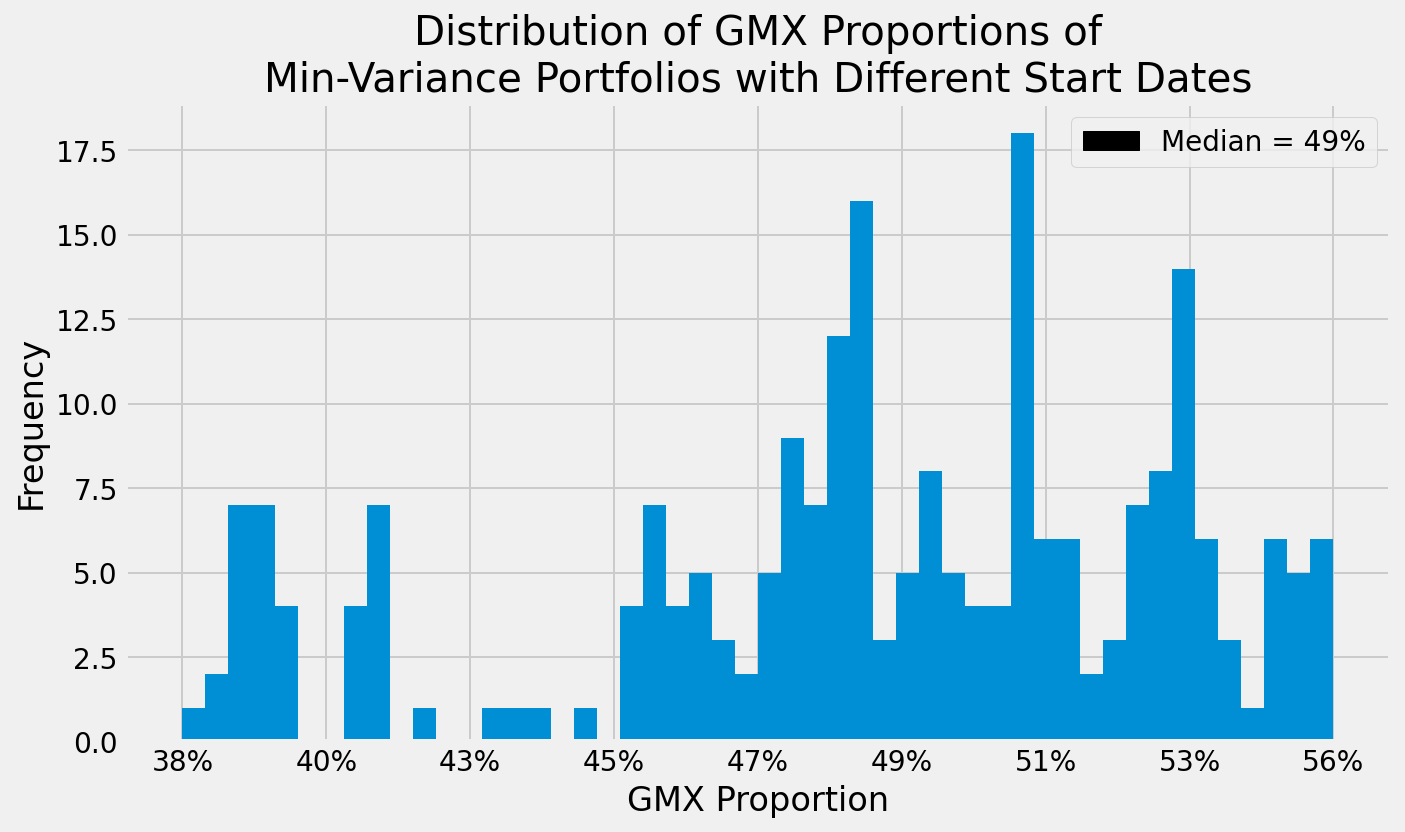

In [22]:
# plot distribution of GMX proportions
fig_title = 'Distribution of GMX Proportions of\nMin-Variance Portfolios with Different Start Dates'
plt_histogram(minvar_portfolios['GMX %'], fig_title, xlab='GMX Proportion')

# make legend to show the median value
med = minvar_portfolios['GMX %'].median()
l1 = mpatches.Patch(color='black',  label='Median = {:.0%}'.format(med))
plt.legend(handles=[l1], loc='upper right')

# save
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'minvar_portfolios_weights_gmx.png'), dpi=300)

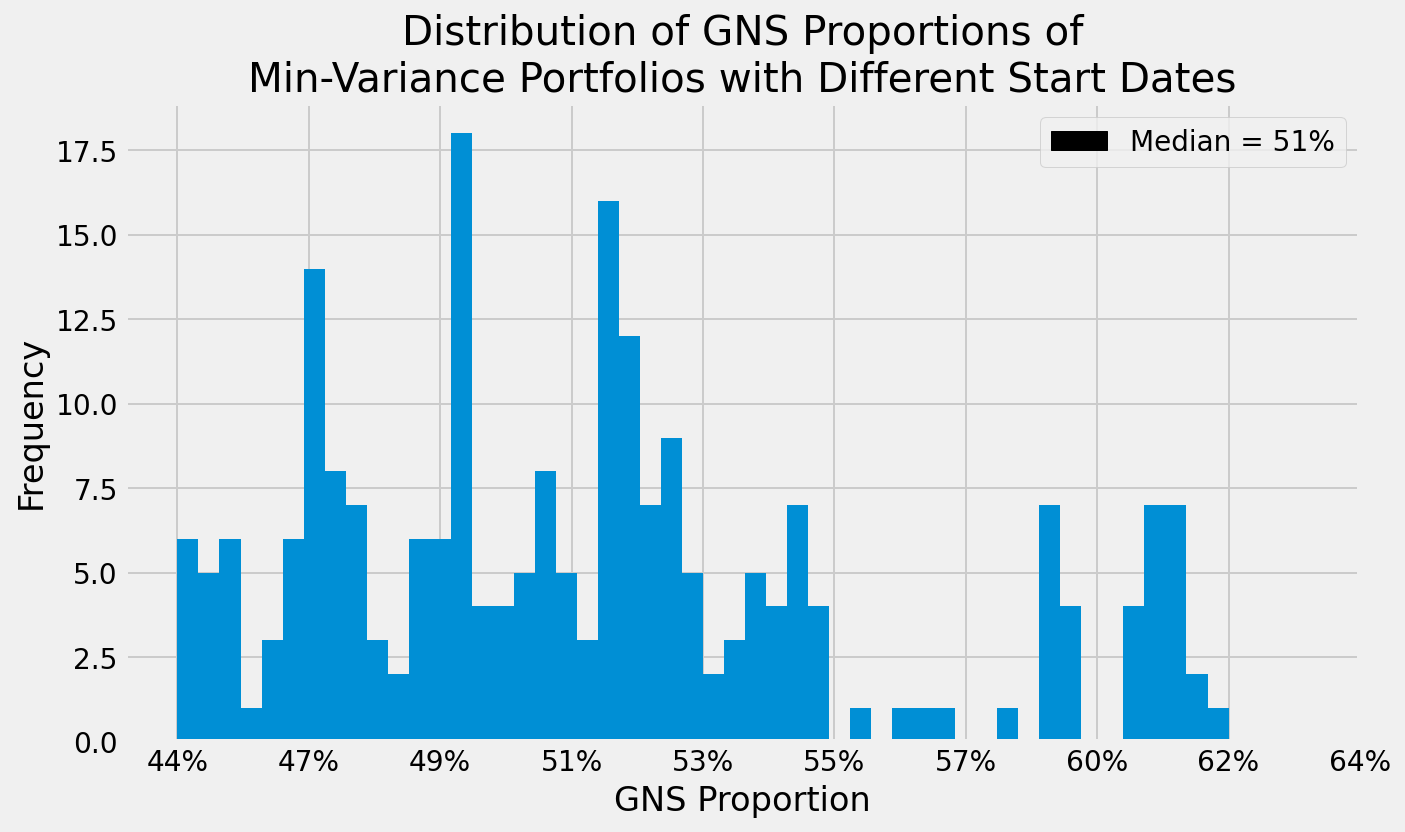

In [23]:
# plot distribution of GNS proportions
fig_title = 'Distribution of GNS Proportions of\nMin-Variance Portfolios with Different Start Dates'
plt_histogram(minvar_portfolios['GNS %'], fig_title, xlab='GNS Proportion')

# make legend to show the median value
med = minvar_portfolios['GNS %'].median()
l1 = mpatches.Patch(color='black',  label='Median = {:.0%}'.format(med))
plt.legend(handles=[l1], loc='upper right')

# save
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'minvar_portfolios_weights_gns.png'), dpi=300)